## Importing Libraries

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

# Step 1 : Data Management

In [5]:
# loading data
inpatient_df = pd.read_csv("D:\\UpGrad\\Projects\\Case Study\\Training Data\\Train_Inpatientdata-1542865627584.csv")
outpatient_df = pd.read_csv("D:\\UpGrad\\Projects\\Case Study\\Training Data\\Train_Outpatientdata-1542865627584.csv")
beneficiary_df = pd.read_csv("D:\\UpGrad\\Projects\\Case Study\\Training Data\\Train_Beneficiarydata-1542865627584.csv")
train_labels_df = pd.read_csv("D:\\UpGrad\\Projects\\Case Study\\Training Data\\Train-1542865627584.csv")

In [6]:
# Checking shape
print("Inpatient:", inpatient_df.shape)
print("Outpatient:", outpatient_df.shape)
print("Beneficiary:", beneficiary_df.shape)
print("Train Labels:", train_labels_df.shape)

Inpatient: (40474, 30)
Outpatient: (517737, 27)
Beneficiary: (138556, 25)
Train Labels: (5410, 2)


In [7]:
# Missing values
print("Missing values summary:\n")
print("Inpatient:\n", inpatient_df.isnull().sum())
print("Outpatient:\n", outpatient_df.isnull().sum())
print("Beneficiary:\n", beneficiary_df.isnull().sum())
print("Train Labels:\n", train_labels_df.isnull().sum())

# Duplicates
print("\nDuplicate rows:")
print("Inpatient:", inpatient_df.duplicated().sum())
print("Outpatient:", outpatient_df.duplicated().sum())
print("Beneficiary:", beneficiary_df.duplicated().sum())
print("Train Labels:", train_labels_df.duplicated().sum())


Missing values summary:

Inpatient:
 BeneID                        0
ClaimID                       0
ClaimStartDt                  0
ClaimEndDt                    0
Provider                      0
InscClaimAmtReimbursed        0
AttendingPhysician          112
OperatingPhysician        16644
OtherPhysician            35784
AdmissionDt                   0
ClmAdmitDiagnosisCode         0
DeductibleAmtPaid           899
DischargeDt                   0
DiagnosisGroupCode            0
ClmDiagnosisCode_1            0
ClmDiagnosisCode_2          226
ClmDiagnosisCode_3          676
ClmDiagnosisCode_4         1534
ClmDiagnosisCode_5         2894
ClmDiagnosisCode_6         4838
ClmDiagnosisCode_7         7258
ClmDiagnosisCode_8         9942
ClmDiagnosisCode_9        13497
ClmDiagnosisCode_10       36547
ClmProcedureCode_1        17326
ClmProcedureCode_2        35020
ClmProcedureCode_3        39509
ClmProcedureCode_4        40358
ClmProcedureCode_5        40465
ClmProcedureCode_6        40474
dty

In [8]:
# Combine inpatient and outpatient claim data
claims_df = pd.concat([inpatient_df, outpatient_df], axis=0, ignore_index=True)

# Merge claims with beneficiary data on 'BeneID'
claims_with_beneficiary = claims_df.merge(beneficiary_df, on='BeneID', how='left')

# Merge with training labels on 'Provider'
train_master_df = claims_with_beneficiary.merge(train_labels_df, on='Provider', how='left')

In [9]:
# final shape and sample
print("Combined Claims Shape:", claims_df.shape)
print("Claims + Beneficiary Shape:", claims_with_beneficiary.shape)
print("Final Merged Training Dataset Shape:", train_master_df.shape)

# Checking if label is missing in any rows
print("Missing PotentialFraud values:", train_master_df['PotentialFraud'].isnull().sum())

train_master_df.head()

Combined Claims Shape: (558211, 30)
Claims + Beneficiary Shape: (558211, 54)
Final Merged Training Dataset Shape: (558211, 55)
Missing PotentialFraud values: 0


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,1,2,1,1,36000,3204,60,70,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,1,1,2,1,1,36000,3204,60,70,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,1,1,2,1,1,36000,3204,60,70,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,1,2,2,1,1,5000,1068,250,320,No
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,2,1,2,2,2,21260,2136,120,100,No


In [10]:
print(train_master_df.columns.tolist())

['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',

# Step 2 : Exploratory Data Analysis (EDA)

**General Information**

In [13]:
# Number of unique providers and beneficiaries
print("Number of unique providers:", train_master_df['Provider'].nunique())
print("Number of unique beneficiaries:", train_master_df['BeneID'].nunique())

# Number of claims per provider (top 5)
claims_per_provider = train_master_df['Provider'].value_counts().head()
print("\nTop 5 Providers by number of claims:\n", claims_per_provider)

# Basic claim amount stats
print("\nInsurance Claim Reimbursement Stats:")
print(train_master_df['InscClaimAmtReimbursed'].describe())

Number of unique providers: 5410
Number of unique beneficiaries: 138556

Top 5 Providers by number of claims:
 Provider
PRV51459    8240
PRV53797    4739
PRV51574    4444
PRV53918    3588
PRV54895    3436
Name: count, dtype: int64

Insurance Claim Reimbursement Stats:
count    558211.000000
mean        997.012133
std        3821.534891
min           0.000000
25%          40.000000
50%          80.000000
75%         300.000000
max      125000.000000
Name: InscClaimAmtReimbursed, dtype: float64


**Class Balance**


PotentialFraud Class Distribution:
 PotentialFraud
No     345415
Yes    212796
Name: count, dtype: int64


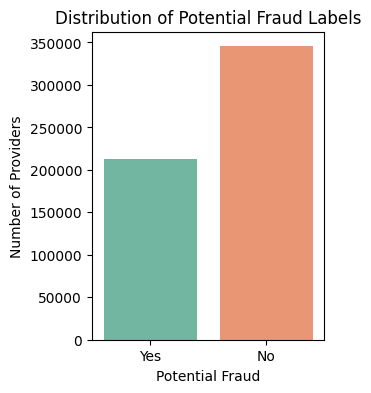

In [15]:
# Class distribution count
fraud_counts = train_master_df['PotentialFraud'].value_counts()
print("\nPotentialFraud Class Distribution:\n", fraud_counts)

# Class distribution plot
plt.figure(figsize=(3,4))
sns.countplot(data=train_master_df, x='PotentialFraud', palette='Set2')
plt.title('Distribution of Potential Fraud Labels')
plt.ylabel('Number of Providers')
plt.xlabel('Potential Fraud')
plt.show()


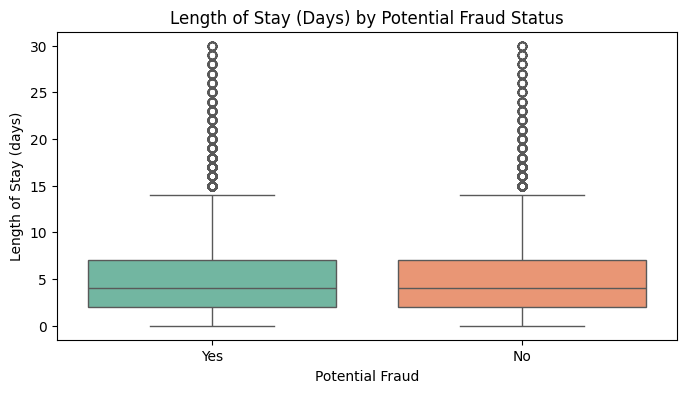

In [16]:
# Convert date columns to datetime
train_master_df['AdmissionDt'] = pd.to_datetime(train_master_df['AdmissionDt'], errors='coerce')
train_master_df['DischargeDt'] = pd.to_datetime(train_master_df['DischargeDt'], errors='coerce')

# Calculate length of stay for inpatient claims only
inpatient_only = train_master_df[train_master_df['AdmissionDt'].notnull() & train_master_df['DischargeDt'].notnull()].copy()
inpatient_only['LengthOfStay'] = (inpatient_only['DischargeDt'] - inpatient_only['AdmissionDt']).dt.days

# Remove extreme outliers (optional)
inpatient_only = inpatient_only[(inpatient_only['LengthOfStay'] >= 0) & (inpatient_only['LengthOfStay'] <= 30)]

# Boxplot of stay duration by fraud status
plt.figure(figsize=(8, 4))
sns.boxplot(data=inpatient_only, x='PotentialFraud', y='LengthOfStay', palette='Set2')
plt.title('Length of Stay (Days) by Potential Fraud Status')
plt.xlabel('Potential Fraud')
plt.ylabel('Length of Stay (days)')
plt.show()

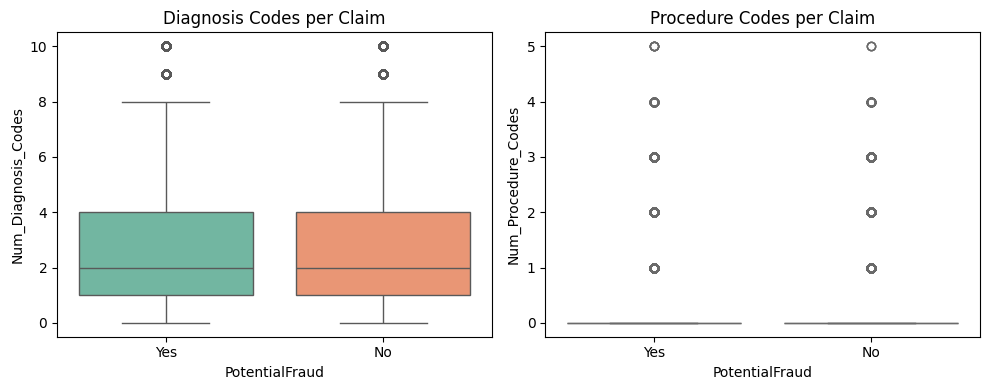

In [17]:
# List of diagnosis and procedure columns
diagnosis_cols = [col for col in train_master_df.columns if 'ClmDiagnosisCode_' in col]
procedure_cols = [col for col in train_master_df.columns if 'ClmProcedureCode_' in col]

# Count non-null diagnoses and procedures
train_master_df['Num_Diagnosis_Codes'] = train_master_df[diagnosis_cols].notnull().sum(axis=1)
train_master_df['Num_Procedure_Codes'] = train_master_df[procedure_cols].notnull().sum(axis=1)

# Boxplots to compare by fraud status
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(data=train_master_df, x='PotentialFraud', y='Num_Diagnosis_Codes', palette='Set2')
plt.title('Diagnosis Codes per Claim')

plt.subplot(1,2,2)
sns.boxplot(data=train_master_df, x='PotentialFraud', y='Num_Procedure_Codes', palette='Set3')
plt.title('Procedure Codes per Claim')
plt.tight_layout()
plt.show()

# Step 3 : Feature Engineering

In [19]:
# Create a copy to avoid changing original
df = train_master_df.copy()

# Flag whether a claim is inpatient (based on presence of admission date)
df['IsInpatient'] = df['AdmissionDt'].notnull().astype(int)

# Group by Provider
provider_df = df.groupby('Provider').agg({
    'ClaimID': 'count',
    'BeneID': pd.Series.nunique,
    'InscClaimAmtReimbursed': ['sum', 'mean'],
    'Num_Diagnosis_Codes': 'mean',
    'Num_Procedure_Codes': 'mean',
    'IsInpatient': 'mean',
    'PotentialFraud': 'first'
})

provider_df.columns = ['TotalClaims', 'UniquePatients', 'TotalClaimAmount', 'AvgClaimAmount',
                       'AvgDiagnosisCodes', 'AvgProcedureCodes', 'InpatientClaimRatio', 'PotentialFraud']

provider_df = provider_df.reset_index()
provider_df.head()

,Provider,TotalClaims,UniquePatients,TotalClaimAmount,AvgClaimAmount,AvgDiagnosisCodes,AvgProcedureCodes,InpatientClaimRatio,PotentialFraud
0,PRV51001,25,24,104640,4185.600000,3.200000,0.120000,0.200000,No
1,PRV51003,132,117,605670,4588.409091,5.250000,0.363636,0.469697,Yes
2,PRV51004,149,138,52170,350.134228,2.583893,0.000000,0.000000,No
3,PRV51005,1165,495,280910,241.124464,2.588841,0.000000,0.000000,Yes
4,PRV51007,72,58,33710,468.194444,2.986111,0.013889,0.041667,No


# Step 4 : Feature Selection

In [21]:
# Encode Target Variable - Convert target variable to numeric
provider_df['FraudFlag'] = provider_df['PotentialFraud'].map({'Yes': 1, 'No': 0})

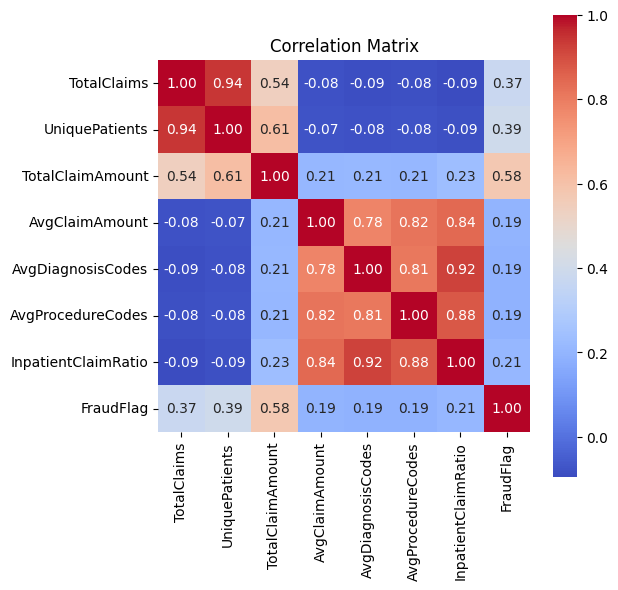

In [22]:
# Numerical features only
features_for_corr = provider_df.drop(columns=['Provider', 'PotentialFraud'])

# Compute correlation matrix
corr = features_for_corr.corr()

# Plot heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

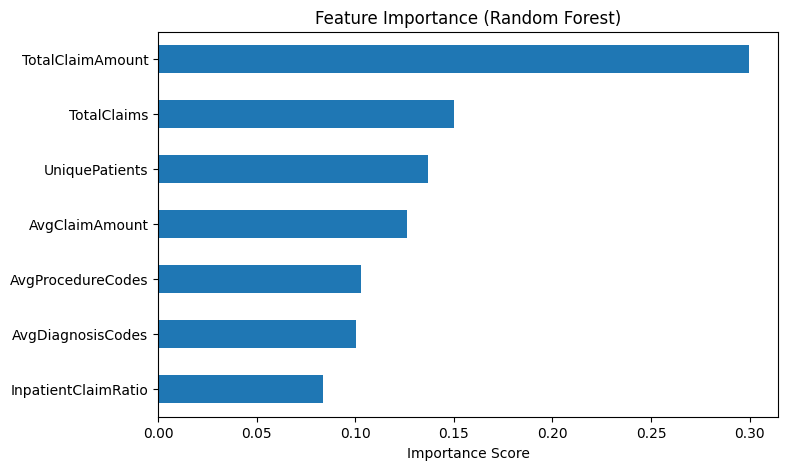

In [23]:
# Features and target
X = provider_df.drop(columns=['Provider', 'PotentialFraud', 'FraudFlag'])
y = provider_df['FraudFlag']

# Train random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
importances.plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

Based on above findings **dropping these features**:
*AvgClaimAmount, UniquePatients,  AvgProcedureCodes*

In [25]:
selected_features = ['TotalClaimAmount', 'TotalClaims', 'AvgDiagnosisCodes', 'InpatientClaimRatio']

# Step 5 : Model Building

**Train/Test Split**

In [28]:
# Final features & target
features = ['TotalClaimAmount', 'TotalClaims', 'AvgDiagnosisCodes', 'InpatientClaimRatio']
X = provider_df[features]
y = provider_df['FraudFlag']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (4328, 4), Test size: (1082, 4)


**Random Forest**

In [30]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]

In [31]:
# Evaluating model
print("Random Forest - Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, rf_pred))

print(f"Random Forest - ROC AUC Score: {roc_auc_score(y_test, rf_prob):.4f}")

Random Forest - Confusion Matrix:
[[958  23]
 [ 44  57]]

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       981
           1       0.71      0.56      0.63       101

    accuracy                           0.94      1082
   macro avg       0.83      0.77      0.80      1082
weighted avg       0.93      0.94      0.93      1082

Random Forest - ROC AUC Score: 0.9272


# Step 6 : Model Evaluation & Interpretation

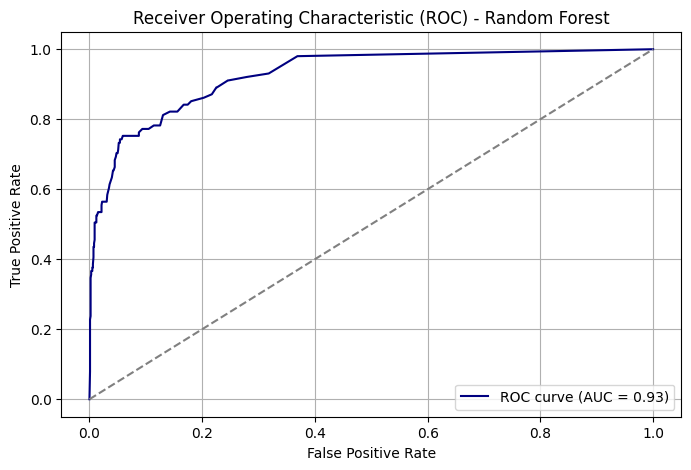

In [33]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, rf_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='navy')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend()
plt.grid(True)
plt.show()

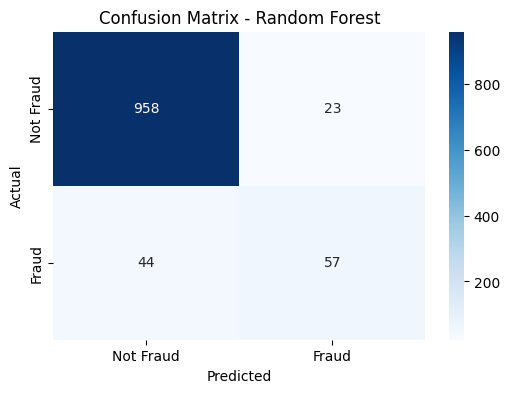

In [34]:
# Confusion matrix plot
cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Making Prediction on Unseen Data

## Step 1 : Prepareing the Data

In [37]:
inpatient_test = pd.read_csv("D:\\UpGrad\\Projects\\Case Study\\Unseen Data\\Unseen_Inpatientdata-1542969243754.csv")
outpatient_test = pd.read_csv("D:\\UpGrad\\Projects\\Case Study\\Unseen Data\\Unseen_Outpatientdata-1542969243754.csv")
beneficiary_test = pd.read_csv("D:\\UpGrad\\Projects\\Case Study\\Unseen Data\\Unseen_Beneficiarydata-1542969243754.csv")
test_labels = pd.read_csv("D:\\UpGrad\\Projects\\Case Study\\Unseen Data\\Unseen-1542969243754.csv")

In [38]:
# Combining inpatient, outpatient and beneficiary
inpatient_test['is_inpatient'] = 1
outpatient_test['is_inpatient'] = 0

claims_test = pd.concat([inpatient_test, outpatient_test], axis=0, ignore_index=True)
# Merge on BeneID
claims_bene_test = claims_test.merge(beneficiary_test, on='BeneID', how='left')

## Step 2 : Engineering the Same Features

In [40]:
# Diagnosis and procedure counts
diagnosis_cols = [f'ClmDiagnosisCode_{i}' for i in range(1, 11)]
procedure_cols = [f'ClmProcedureCode_{i}' for i in range(1, 7)]

claims_bene_test['DiagnosisCount'] = claims_bene_test[diagnosis_cols].notna().sum(axis=1)
claims_bene_test['ProcedureCount'] = claims_bene_test[procedure_cols].notna().sum(axis=1)

**Grouping by Provider**

In [42]:
provider_test_features = claims_bene_test.groupby('Provider').agg({
    'ClaimID': 'count',
    'BeneID': pd.Series.nunique,
    'InscClaimAmtReimbursed': 'sum',
    'DiagnosisCount': 'mean',
    'ProcedureCount': 'mean',
    'is_inpatient': 'mean'
}).reset_index()

provider_test_features.columns = ['Provider', 'TotalClaims', 'UniquePatients', 'TotalClaimAmount',
                                  'AvgDiagnosisCodes', 'AvgProcedureCodes', 'InpatientClaimRatio']

## Step 3 : Predicting using trained model

In [44]:
X_test_unseen = provider_test_features[selected_features]

# Predict
test_preds = rf.predict(X_test_unseen)
test_probs = rf.predict_proba(X_test_unseen)[:, 1]

# Add predictions to dataframe
provider_test_features['PotentialFraud'] = test_preds
provider_test_features['PotentialFraud'] = provider_test_features['PotentialFraud'].map({1: 'Yes', 0: 'No'})

**Saving Prediction file**

In [46]:
submission = provider_test_features[['Provider', 'PotentialFraud']].copy()
submission['Fraud_Probability'] = test_probs
submission = submission[['Provider', 'Fraud_Probability', 'PotentialFraud']]
submission.to_csv('Adit Kumar Yadav_Submission.csv', index=False)
print("Adit Kumar Yadav_Submission.csv")

Adit Kumar Yadav_Submission.csv


**Count Fraud vs Non-Fraud Predictions**

In [48]:
# Count predicted frauds and non-frauds
fraud_counts = provider_test_features['PotentialFraud'].value_counts()
print("Predicted Fraud Counts:\n", fraud_counts)

Predicted Fraud Counts:
 PotentialFraud
No     1287
Yes      66
Name: count, dtype: int64


In [49]:
# Display top fraudulent providers
fraudulent_providers = provider_test_features[provider_test_features['PotentialFraud'] == 'Yes']
print("Top 5 Fraudulent Providers:\n", fraudulent_providers.head())

Top 5 Fraudulent Providers:
      Provider  TotalClaims  UniquePatients  TotalClaimAmount  \
15   PRV51073          143             105           1035020   
86   PRV51407          344             318           2922290   
182  PRV51939         1804             588            487320   
185  PRV51955          200             164            390060   
190  PRV51982          181             164           1078600   

     AvgDiagnosisCodes  AvgProcedureCodes  InpatientClaimRatio PotentialFraud  
15            6.237762           0.398601             0.629371            Yes  
86            6.796512           0.505814             0.790698            Yes  
182           2.616962           0.000554             0.000000            Yes  
185           3.310000           0.145000             0.195000            Yes  
190           5.867403           0.497238             0.591160            Yes  


In [50]:
# Split into fraud and non-fraud groups
fraud_providers = provider_test_features[provider_test_features['PotentialFraud'] == 'Yes']
nonfraud_providers = provider_test_features[provider_test_features['PotentialFraud'] == 'No']

# Describe key metrics
metrics = ['TotalClaims', 'TotalClaimAmount', 'AvgDiagnosisCodes', 'AvgProcedureCodes', 'InpatientClaimRatio']
fraud_summary = fraud_providers[metrics].describe()
nonfraud_summary = nonfraud_providers[metrics].describe()

print("Fraudulent Providers Summary:\n", fraud_summary)
print("\nNon-Fraudulent Providers Summary:\n", nonfraud_summary)

Fraudulent Providers Summary:
        TotalClaims  TotalClaimAmount  AvgDiagnosisCodes  AvgProcedureCodes  \
count    66.000000      6.600000e+01          66.000000          66.000000   
mean    600.848485      9.154030e+05           4.660764           0.280341   
std     811.285272      9.753348e+05           1.726552           0.247512   
min      11.000000      1.680000e+05           2.505809           0.000000   
25%     103.000000      3.448600e+05           2.965385           0.062817   
50%     203.500000      5.836000e+05           4.550357           0.239530   
75%     764.250000      1.081682e+06           6.071490           0.480057   
max    3250.000000      6.097440e+06           8.600000           1.090909   

       InpatientClaimRatio  
count            66.000000  
mean              0.373634  
std               0.308587  
min               0.000000  
25%               0.080902  
50%               0.345384  
75%               0.634615  
max               1.000000  

Non-

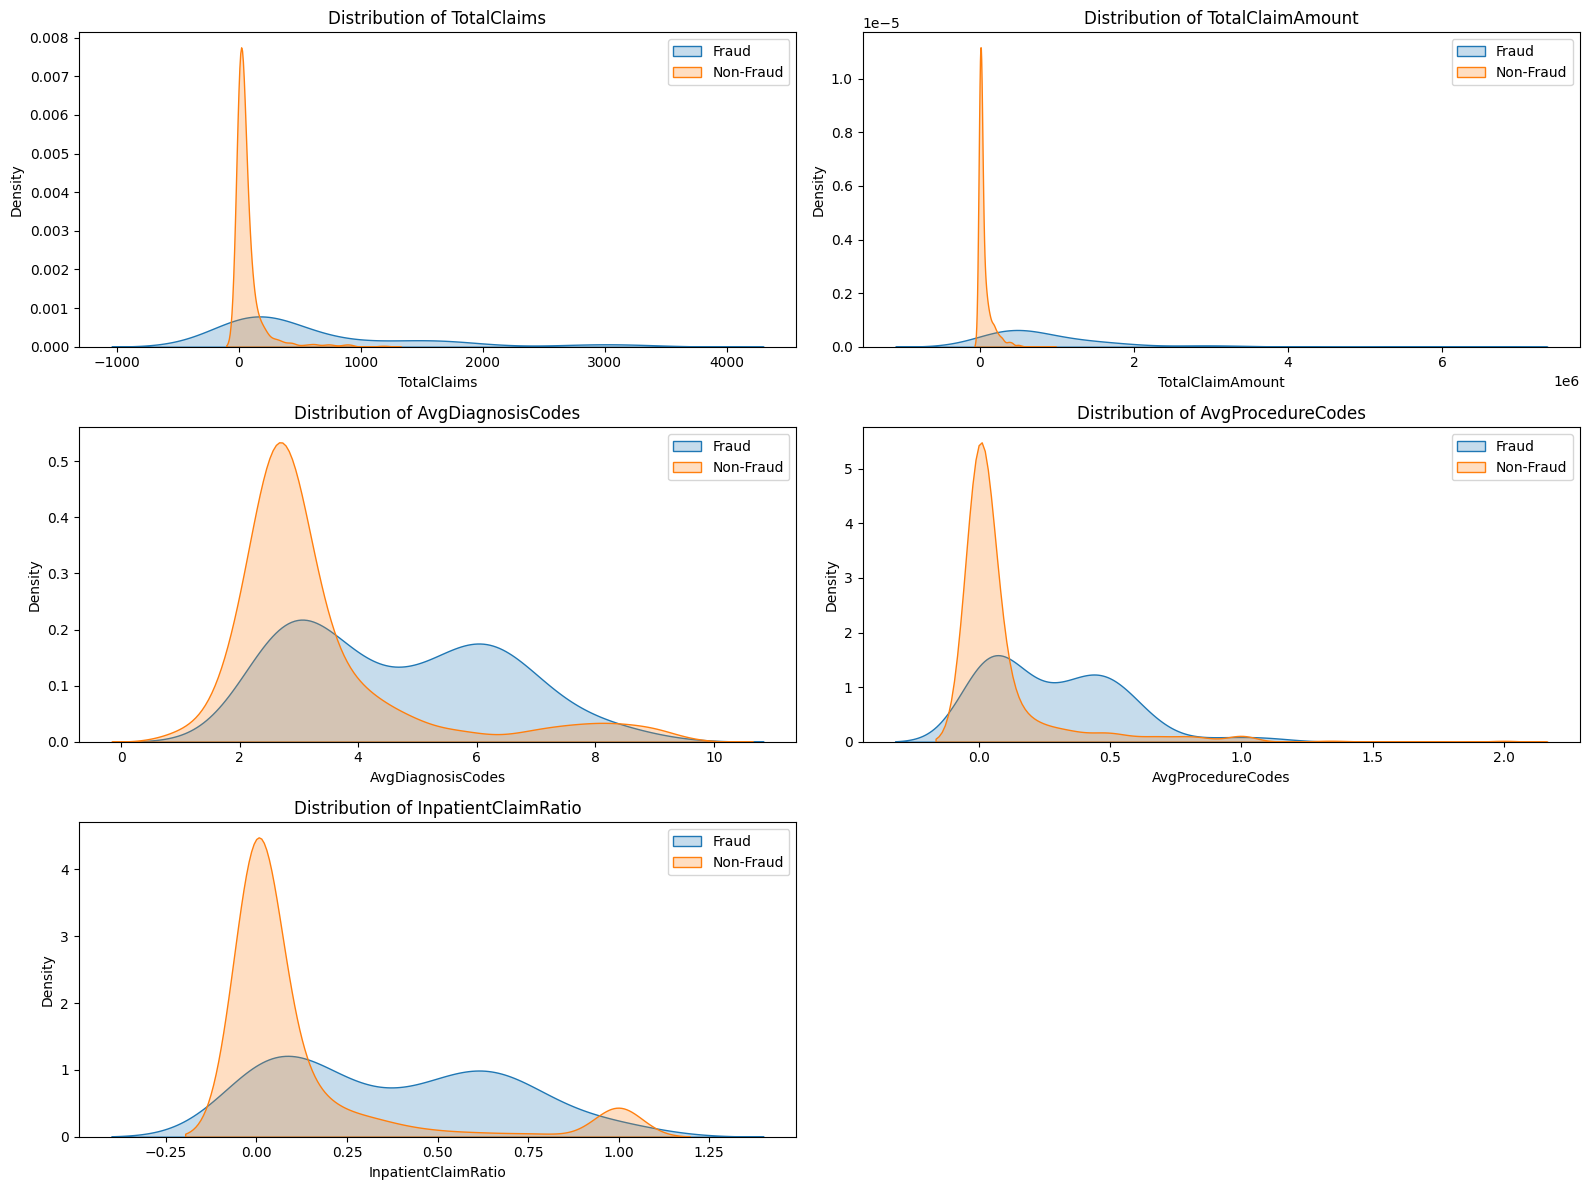

In [51]:
# Plot distributions side by side
plt.figure(figsize=(16, 12))

for i, col in enumerate(metrics):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(fraud_providers[col], label='Fraud', shade=True)
    sns.kdeplot(nonfraud_providers[col], label='Non-Fraud', shade=True)
    plt.title(f'Distribution of {col}')
    plt.legend()

plt.tight_layout()
plt.show()

In [52]:
print("Mean Values - Fraudulent Providers:")
print(fraud_providers[metrics].mean())

print("\nMean Values - Non-Fraudulent Providers:")
print(nonfraud_providers[metrics].mean())

Mean Values - Fraudulent Providers:
TotalClaims               600.848485
TotalClaimAmount       915403.030303
AvgDiagnosisCodes           4.660764
AvgProcedureCodes           0.280341
InpatientClaimRatio         0.373634
dtype: float64

Mean Values - Non-Fraudulent Providers:
TotalClaims               74.386946
TotalClaimAmount       56289.541570
AvgDiagnosisCodes          3.327361
AvgProcedureCodes          0.092576
InpatientClaimRatio        0.126206
dtype: float64


# Creating Visualizations for Summary Report

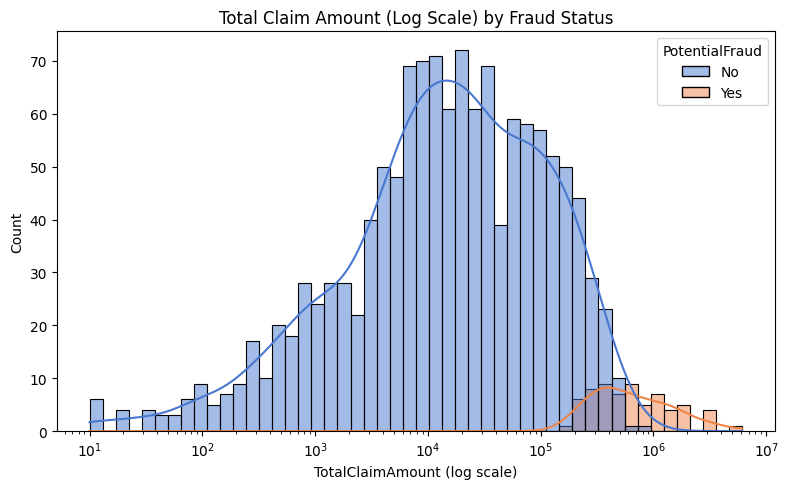

In [54]:
# Remove NaNs and zeros before plotting
filtered_data = provider_test_features.copy()
filtered_data = filtered_data[filtered_data['TotalClaimAmount'].notna()]
filtered_data = filtered_data[filtered_data['TotalClaimAmount'] > 0]

plt.figure(figsize=(8, 5))
sns.histplot(
    data=filtered_data,
    x='TotalClaimAmount',
    hue='PotentialFraud',
    log_scale=True,
    bins=50,
    kde=True,
    palette='muted'
)
plt.title('Total Claim Amount (Log Scale) by Fraud Status')
plt.xlabel('TotalClaimAmount (log scale)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

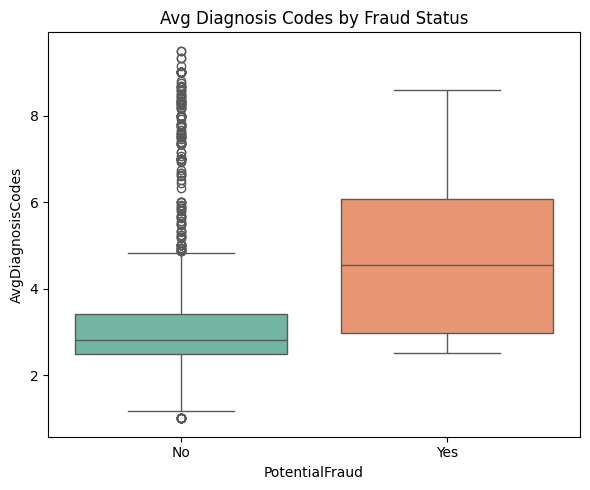

In [55]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=provider_test_features, x='PotentialFraud', y='AvgDiagnosisCodes', palette='Set2')
plt.title('Avg Diagnosis Codes by Fraud Status')
plt.ylabel('AvgDiagnosisCodes')
plt.xlabel('PotentialFraud')
plt.tight_layout()
plt.show()

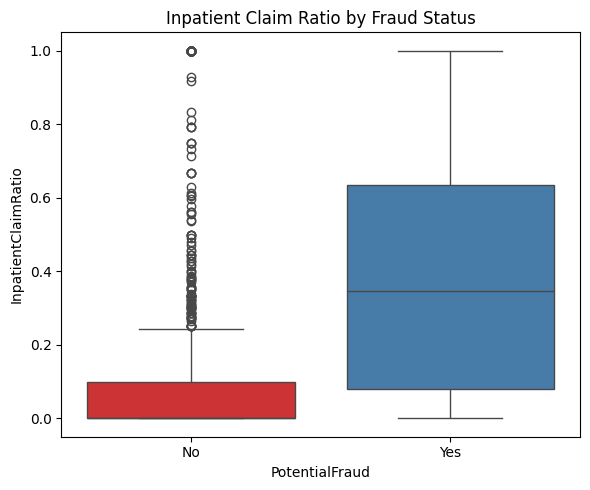

In [56]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=provider_test_features, x='PotentialFraud', y='InpatientClaimRatio', palette='Set1')
plt.title('Inpatient Claim Ratio by Fraud Status')
plt.ylabel('InpatientClaimRatio')
plt.xlabel('PotentialFraud')
plt.tight_layout()
plt.show()

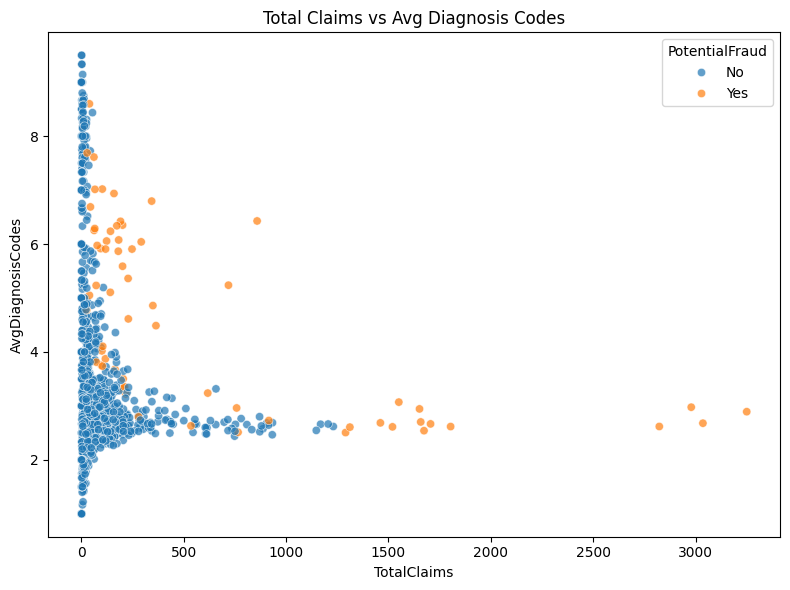

In [57]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=provider_test_features, x='TotalClaims', y='AvgDiagnosisCodes', hue='PotentialFraud', alpha=0.7)
plt.title('Total Claims vs Avg Diagnosis Codes')
plt.xlabel('TotalClaims')
plt.ylabel('AvgDiagnosisCodes')
plt.legend(title='PotentialFraud')
plt.tight_layout()
plt.show()

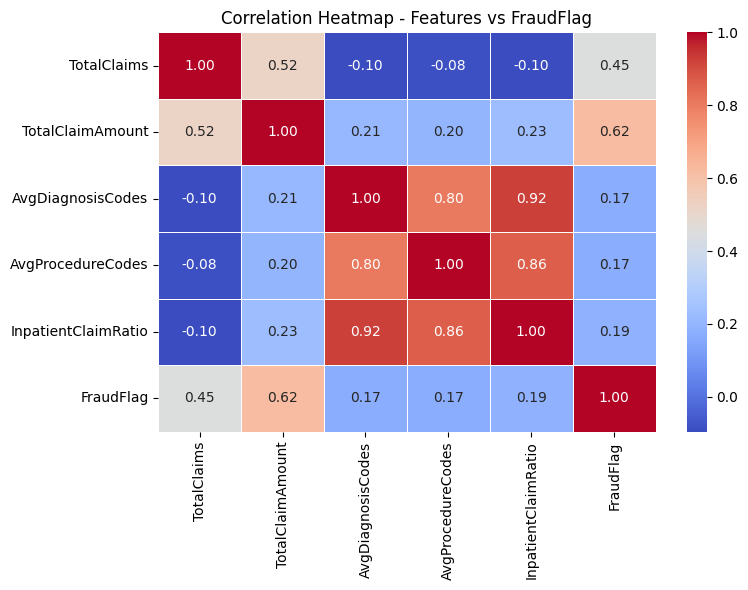

In [58]:
# Select numeric columns
features_to_plot = ['TotalClaims', 'TotalClaimAmount', 'AvgDiagnosisCodes', 
                    'AvgProcedureCodes', 'InpatientClaimRatio']

# Add fraud as binary flag
provider_test_features['FraudFlag'] = provider_test_features['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Compute correlations
corr = provider_test_features[features_to_plot + ['FraudFlag']].corr()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap - Features vs FraudFlag")
plt.tight_layout()
plt.show()